<a href="https://colab.research.google.com/github/blessingnwogu/MS-Thesis/blob/main/MS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis

### Import Libraries and Set the intial variables

In [ ]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


### Load the data

In [ ]:
df = pd.read_csv('drug_review_train.csv')


## EDA

In [ ]:
df.head() #


,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,class_2ways,input_text
88136,8136,104770,Ethinyl estradiol / levonorgestrel,birth control,"""i've been on aviane for a little over a year....",9.0,"October 13, 2010",0,87,1,"""i've been on aviane for a little over a year...."
100915,915,89564,Celexa,depression,"""i was diagnosed with obsessive compulsive dis...",9.0,"January 23, 2012",25,123,1,"""i was diagnosed with obsessive compulsive dis..."
61175,1175,116281,Adalimumab,ulcerative colitis,"""i was put on humira on june 10, 2015 for seve...",1.0,"September 17, 2015",28,136,0,"""i was put on humira on june 10, 2015 for seve..."
15209,5209,119319,Testosterone,"hypogonadism, male","""i tried andro-gel for about 6-8 months. i did...",4.0,"December 19, 2015",3,74,0,"""i tried andro-gel for about 6-8 months. i did..."
100666,666,29069,Topiramate,obesity,"""i'm calling this the 'closer to perfection dr...",10.0,"April 20, 2017",45,140,1,"""i'm calling this the 'closer to perfection dr..."


In [ ]:
print(df.shape) # print shape

(110811, 9)


In [ ]:
df = df.sample(n=10000, random_state=42)
df.shape

(10000, 9)

In [ ]:
# Let's check for missing values
df.isnull().sum()

Unnamed: 0       0
patient_id       0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

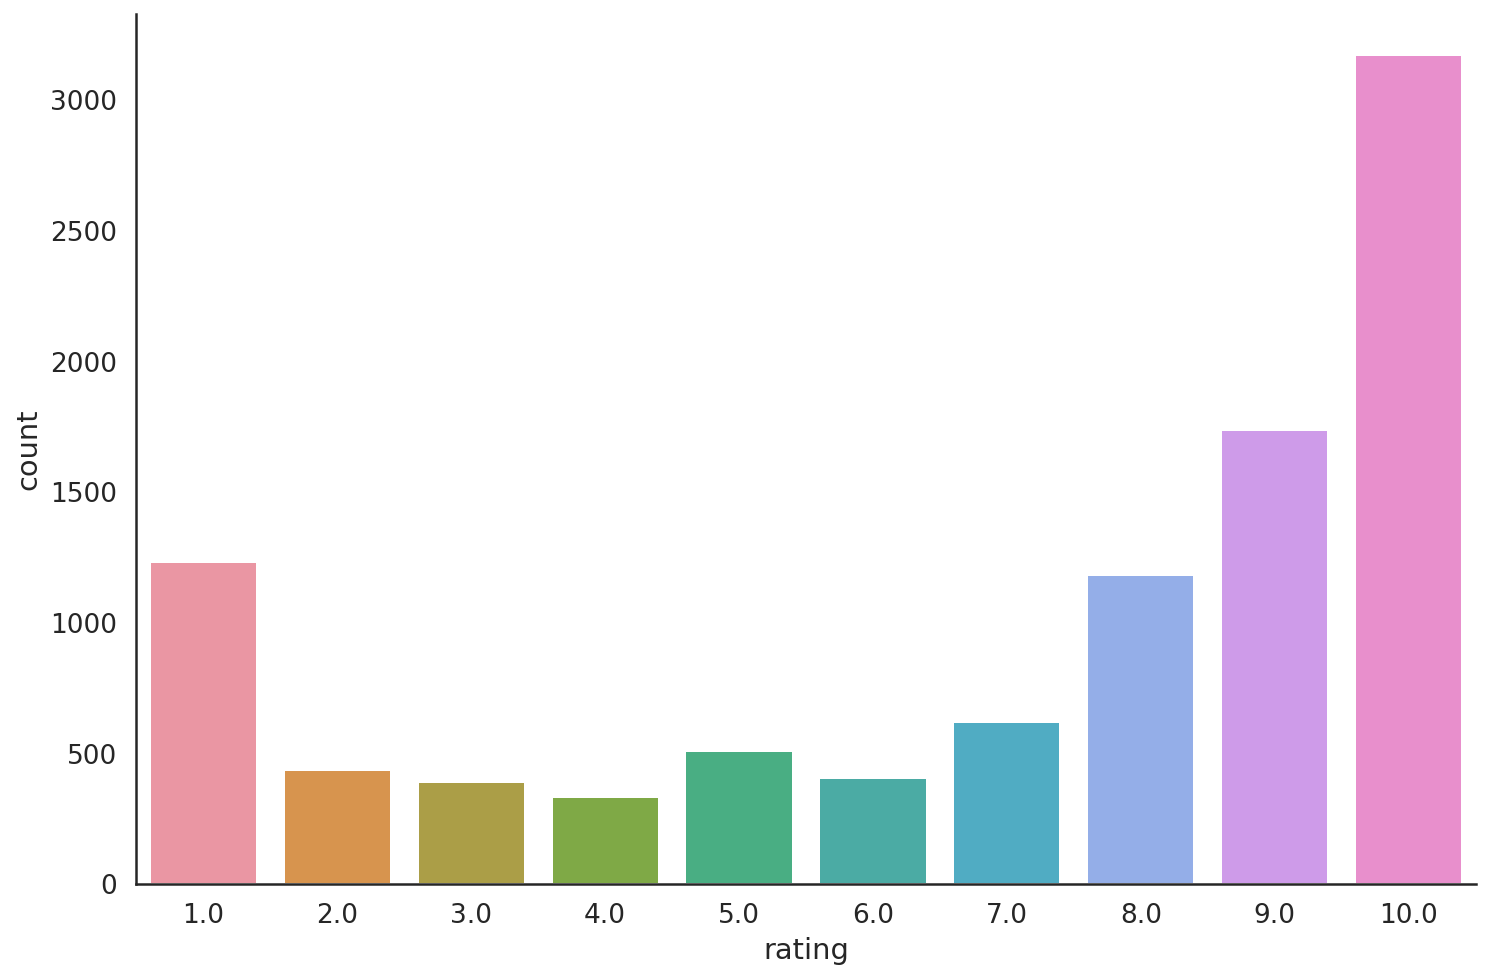

In [ ]:
# Let's have a look at the class balance.
sns.countplot(df.rating)
plt.xlabel('rating');

## Prepeprocessing
class_2ways will be just positive and negative, where positive is 6+ and negative is 1 through 5

class_3ways will be psitive neutral and negative, wher positive is 7+, neutral is 4 through 6 and negative is 1 through 3

In [ ]:
df['class_2ways'] = np.where(df['rating'] >= 5, 'positive', 'negative')


In [ ]:
df

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,class_2ways
88136,8136,104770,Ethinyl estradiol / levonorgestrel,birth control,"""i've been on aviane for a little over a year....",9.0,"October 13, 2010",0,87,positive
100915,915,89564,Celexa,depression,"""i was diagnosed with obsessive compulsive dis...",9.0,"January 23, 2012",25,123,positive
61175,1175,116281,Adalimumab,ulcerative colitis,"""i was put on humira on june 10, 2015 for seve...",1.0,"September 17, 2015",28,136,negative
15209,5209,119319,Testosterone,"hypogonadism, male","""i tried andro-gel for about 6-8 months. i did...",4.0,"December 19, 2015",3,74,negative
100666,666,29069,Topiramate,obesity,"""i'm calling this the 'closer to perfection dr...",10.0,"April 20, 2017",45,140,positive
...,...,...,...,...,...,...,...,...,...,...
16632,6632,209128,Mucinex D Maximum Strength,cough and nasal congestion,"""my doctor told me that the key to mucinex wor...",10.0,"December 18, 2015",2,100,positive
63457,3457,142761,Levonorgestrel,birth control,"""i had the kyleena inserted today. i was very ...",10.0,"July 13, 2017",3,75,positive
22581,2581,201514,Zoloft,panic disorde,"""i promised to come back and do a review of th...",9.0,"January 13, 2014",93,126,positive
30922,922,194457,Atorvastatin,high cholesterol,"""my dr has me on atorvastatin 80 mgs. i did n...",1.0,"November 5, 2017",2,100,negative


## Data Visualization

In [ ]:
# Two classes

# Get the counts
class_count1 = df['class_2ways'].value_counts()

# Print the counts
print("Class distribution:")
print(class_count1)

# If you want to see the percentages as well
print("\nClass distribution (percentage):")
print(df['class_2ways'].value_counts(normalize=True) * 100)

# To get individual counts
df_positive_count = class_count1['positive']
df_negative_count = class_count1['negative']

print(f"\nPositive count: {df_positive_count}")
print(f"Negative count: {df_negative_count}")


Class distribution:
positive    7617
negative    2383
Name: class_2ways, dtype: int64

Class distribution (percentage):
positive    76.17
negative    23.83
Name: class_2ways, dtype: float64

Positive count: 7617
Negative count: 2383


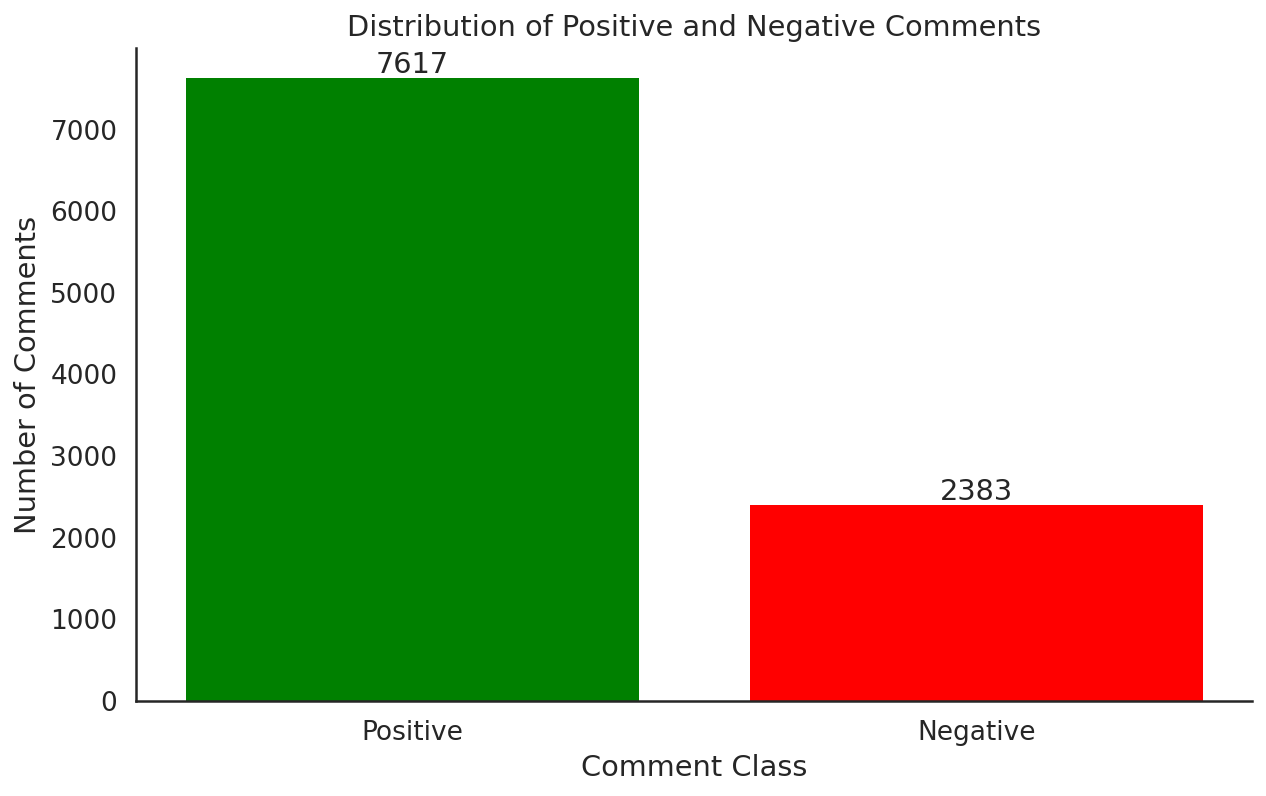

In [ ]:
# Two classes

import matplotlib.pyplot as plt

classes = ['Positive', 'Negative']
counts = [df_positive_count, df_negative_count]

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts)

# Customize the chart
plt.title('Distribution of Positive and Negative Comments')
plt.xlabel('Comment Class')
plt.ylabel('Number of Comments')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Add colors
bars[0].set_color('green')
bars[1].set_color('red')

plt.show()

In [ ]:
df_balanced.review[4870]

# Data Preprocessing



In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [ ]:
# Store length of each review
token_lens = []

# Iterate through the review column
for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

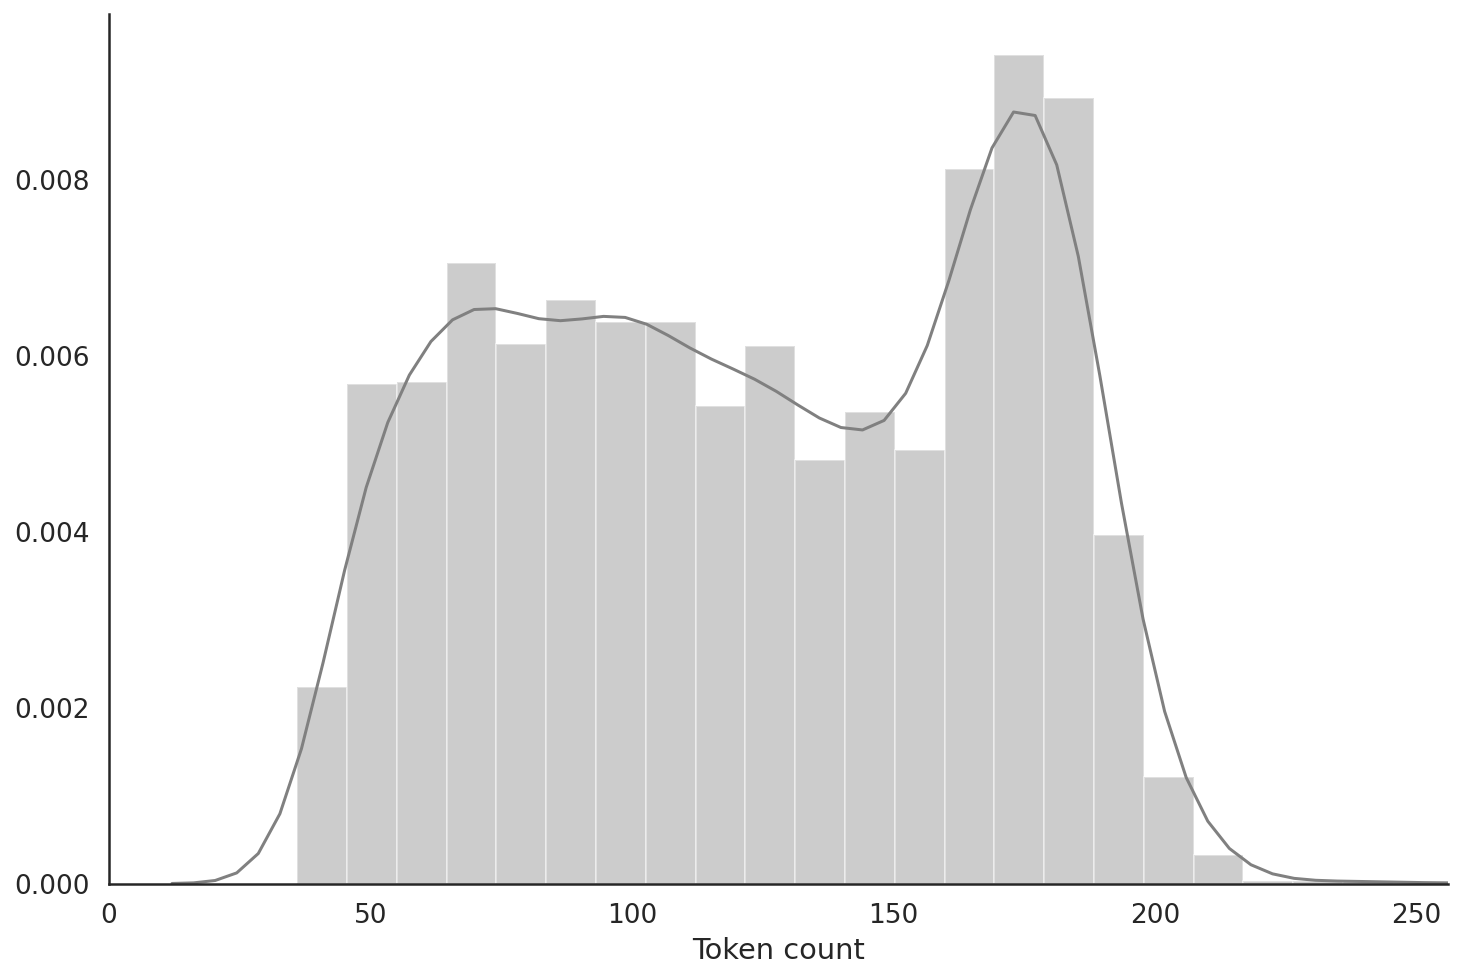

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 190 tokens,

In [ ]:
MAX_LEN = 220

# BERT

Oversampling For BERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Combine review, drugName, and condition into a single text column
df['input_text'] = df['review'] + ' [SEP] ' + df['drugName'] + ' [SEP] ' + df['condition']

# Encode the labels for class_2ways
label_encoder_2ways = LabelEncoder()
df['class_2ways'] = label_encoder_2ways.fit_transform(df['class_2ways'])

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) #train  80%, test 20%

# Separate features and labels for oversampling
X_train = train_df['input_text'].values.reshape(-1, 1)  # Reshape for RandomOverSampler
y_train_2ways = train_df['class_2ways']




In [ ]:
# Apply Random Oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train_2ways)

# Create a new DataFrame from the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=['input_text'])
resampled_df['class_2ways'] = y_resampled

# Prepare data for both tasks
train_texts, val_texts = resampled_df['input_text'].tolist(), val_df['input_text'].tolist()
train_labels_2ways, val_labels_2ways = resampled_df['class_2ways'].tolist(), val_df['class_2ways'].tolist()

#Check the new class distribution for class_2ways
print("Resampled class distribution (class_2ways):", Counter(y_resampled))

Resampled class distribution (class_2ways): Counter({1: 6111, 0: 6111})


In [ ]:
from collections import Counter

print("Resampled training set class distribution (class_2ways):", Counter(y_resampled))
print("Validation set class distribution (class_2ways):", Counter(val_df['class_2ways']))


Resampled training set class distribution (class_2ways): Counter({1: 6111, 0: 6111})
Validation set class distribution (class_2ways): Counter({1: 1506, 0: 494})


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_2ways = ReviewDataset(train_encodings, train_labels_2ways)
val_dataset_2ways = ReviewDataset(val_encodings, val_labels_2ways)

from transformers import BertForSequenceClassification

# Initialize model for class_2ways (binary classification)
model_2ways = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader_2ways = DataLoader(train_dataset_2ways, batch_size=16, shuffle=True)
val_loader_2ways = DataLoader(val_dataset_2ways, batch_size=16, shuffle=False)

# Optimizer
optimizer = AdamW(model_2ways.parameters(), lr=2e-5)

# Learning rate scheduler using LambdaLR
num_epochs = 3
num_training_steps = num_epochs * len(train_loader_2ways)

# Linear scheduler with warmup
def lr_lambda(current_step: int):
    warmup_steps = 0
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - warmup_steps)))

lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Training loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_2ways.to(device)

for epoch in range(num_epochs):
    model_2ways.train()
    for batch in train_loader_2ways:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Pass labels during the forward pass to get the loss automatically
        outputs = model_2ways(**batch, return_dict=True)

        # Access the loss from the returned dictionary
        loss = outputs['loss']
        loss.backward()

        optimizer.step()
        lr_scheduler.step()  # Use the PyTorch LambdaLR scheduler
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}/{num_epochs} completed.")



Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.


In [ ]:
from sklearn.metrics import accuracy_score

# Evaluation loop for class_2ways
model_2ways.eval()
predictions = []
true_labels = []

for batch in val_loader_2ways:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        # Ensure return_dict=True to access logits easily
        outputs = model_2ways(**batch, return_dict=True)

    # Access logits from the outputs dictionary
    logits = outputs['logits']

    # Get predicted class labels
    predictions.append(logits.argmax(dim=-1).cpu().numpy())
    true_labels.append(batch['labels'].cpu().numpy())

# Flatten the predictions and true labels lists
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f"Validation Accuracy (class_2ways): {accuracy}")

Validation Accuracy (class_2ways): 0.864


In [ ]:
report = classification_report(true_labels, predictions, target_names=['Negative', 'Postivive'])
print("BERT Classification Report (class_2ways):")
print(report)

BERT Classification Report (class_2ways):
              precision    recall  f1-score   support

    Negative       0.75      0.68      0.71       494
   Postivive       0.90      0.92      0.91      1506

    accuracy                           0.86      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.86      0.86      0.86      2000



# LSTM

In [ ]:
# Tokenize the text data to convert words into sequences of integers
max_words = 10000  # Maximum number of unique words to consider
max_len = 220  # Maximum length of sequences after padding

tokenizer = Tokenizer(num_words=max_words)  # Initialize the tokenizer with max words limit
tokenizer.fit_on_texts(X_train_resampled.iloc[:, 0])  # Fit the tokenizer on the resampled training texts

# Convert texts to sequences of integers using the fitted tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train_resampled.iloc[:, 0])
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size for LSTM
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)



In [ ]:
import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical operations
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels
from imblearn.over_sampling import RandomOverSampler  # For random oversampling to balance classes
from tensorflow.keras.preprocessing.text import Tokenizer  # For text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to a uniform length
from tensorflow.keras.models import Sequential  # For creating a sequential model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # For adding layers to the model
from tensorflow.keras.optimizers import Adam  # For the Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping  # For early stopping during training
from sklearn.metrics import classification_report, accuracy_score  # For evaluating model performance



# Combine review, drugName, and condition into a single text column
df['input_text'] = df['review'] + ' [SEP] ' + df['drugName'] + ' [SEP] ' + df['condition']

# # Encode the labels for class_2ways into numerical format (0 and 1)
label_encoder = LabelEncoder()
df['class_2ways'] = label_encoder.fit_transform(df['class_2ways'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['input_text'], df['class_2ways'], test_size=0.2, random_state=42)

# Apply random oversampling to the training data to balance class distribution
ros = RandomOverSampler(random_state=42)  # Initialize the oversampler
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)  # Fit and resample





    'embedding_dim': [100, 200, 300],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'optimizer': ['adam', 'rmsprop']


In [ ]:
Simple LSTM Model

In [ ]:
# Create the LSTM model using a sequential approach
model = Sequential([
    Embedding(max_words, 100, input_length=max_len),  # Embedding layer for word representation
    LSTM(128, return_sequences=True),  # First LSTM layer with output sequences for stacking another LSTM layer
    LSTM(64),  # Second LSTM layer with reduced units
    Dense(32, activation='relu'),  # Dense layer with ReLU activation for non-linearity
    Dropout(0.5),  # Dropout layer for regularization to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification (0 or 1)
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_resampled,  # Training data and labels
    epochs=10,  # Number of epochs for training
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Use 20% of training data for validation during training
    callbacks=[early_stopping]  # Include early stopping callback
)



Epoch 1/10
306/306 [==============================] - 78s 255ms/step - loss: 0.4831 - accuracy: 0.7771 - val_loss: 0.5039 - val_accuracy: 0.8037
Epoch 2/10
306/306 [==============================] - 76s 249ms/step - loss: 0.2713 - accuracy: 0.8985 - val_loss: 0.3083 - val_accuracy: 0.8998
Epoch 3/10
306/306 [==============================] - 77s 253ms/step - loss: 0.1743 - accuracy: 0.9422 - val_loss: 0.2483 - val_accuracy: 0.9133
Epoch 4/10
306/306 [==============================] - 77s 253ms/step - loss: 0.1125 - accuracy: 0.9662 - val_loss: 0.0928 - val_accuracy: 0.9816
Epoch 5/10
306/306 [==============================] - 77s 251ms/step - loss: 0.0716 - accuracy: 0.9803 - val_loss: 0.0588 - val_accuracy: 0.9861
Epoch 6/10
306/306 [==============================] - 77s 252ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0735 - val_accuracy: 0.9800
Epoch 7/10
306/306 [==============================] - 77s 253ms/step - loss: 0.0340 - accuracy: 0.9909 - val_loss: 0.0398 - val_ac

In [ ]:
# Evaluate the model on the test set to check performance
y_pred = model.predict(X_test_pad)  # Get predictions from the model on test data
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary class predictions

# Print accuracy score and classification report for detailed evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.7935

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       494
           1       0.85      0.88      0.86      1506

    accuracy                           0.79      2000
   macro avg       0.72      0.71      0.71      2000
weighted avg       0.79      0.79      0.79      2000



Bi-directional LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Embedding(max_words, 300, input_length=max_len),  # Embedding with higher dimension or pre-trained embeddings
    Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2)),  # First Bidirectional LSTM layer
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  # Second Bidirectional LSTM layer
    Dense(128, activation='relu'),  # Increased units in Dense layer
    Dropout(0.3),  # Slightly reduced dropout rate
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for better training control
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Training

history = model.fit(
    X_train_pad, y_train_resampled,  # Training data and labels
    epochs=10,  # Number of epochs for training
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Use 20% of training data for validation during training
    callbacks=[early_stopping, reduce_lr])  # Include early stopping callback


Epoch 1/10
306/306 [==============================] - 594s 2s/step - loss: 0.5537 - accuracy: 0.7100 - val_loss: 0.5005 - val_accuracy: 0.8090
Epoch 2/10
306/306 [==============================] - 594s 2s/step - loss: 0.2917 - accuracy: 0.8843 - val_loss: 0.3687 - val_accuracy: 0.8699
Epoch 3/10
306/306 [==============================] - 594s 2s/step - loss: 0.1888 - accuracy: 0.9339 - val_loss: 0.1144 - val_accuracy: 0.9693
Epoch 4/10
306/306 [==============================] - 593s 2s/step - loss: 0.1243 - accuracy: 0.9603 - val_loss: 0.1136 - val_accuracy: 0.9701
Epoch 5/10
306/306 [==============================] - 595s 2s/step - loss: 0.0829 - accuracy: 0.9741 - val_loss: 0.0774 - val_accuracy: 0.9849
Epoch 6/10
306/306 [==============================] - 595s 2s/step - loss: 0.0595 - accuracy: 0.9819 - val_loss: 0.0572 - val_accuracy: 0.9881
Epoch 7/10
306/306 [==============================] - 594s 2s/step - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0632 - val_accuracy: 0.9857

In [ ]:
# Evaluate the model on the test set to check performance
y_pred = model.predict(X_test_pad)  # Get predictions from the model on test data
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary class predictions

# Print accuracy score and classification report for detailed evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.8185

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.53      0.59       494
           1       0.86      0.91      0.88      1506

    accuracy                           0.82      2000
   macro avg       0.76      0.72      0.74      2000
weighted avg       0.81      0.82      0.81      2000



# Traditional ML

Preprocessing with Lemmatization

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Combine the relevant text columns for features
df['combined_text'] = df['drugName'] + " " + df['condition'] + " " + df['review']

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_lemma(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Apply the function to your DataFrame
df['processed_review_lemma'] = df['combined_text'].apply(preprocess_text_lemma)

# Features Labels
X = df['processed_review_lemma']
y_class_2ways = df['class_2ways']





[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,class_2ways,class_3ways,combined_text,processed_review_lemma
88136,8136,104770,Ethinyl estradiol / levonorgestrel,birth control,"""i've been on aviane for a little over a year....",9.0,"October 13, 2010",0,87,positive,positive,Ethinyl estradiol / levonorgestrel birth contr...,ethinyl estradiol levonorgestrel birth control...
100915,915,89564,Celexa,depression,"""i was diagnosed with obsessive compulsive dis...",9.0,"January 23, 2012",25,123,positive,positive,"Celexa depression ""i was diagnosed with obsess...",celexa depression diagnosed obsessive compulsi...
61175,1175,116281,Adalimumab,ulcerative colitis,"""i was put on humira on june 10, 2015 for seve...",1.0,"September 17, 2015",28,136,negative,negative,"Adalimumab ulcerative colitis ""i was put on hu...",adalimumab ulcerative colitis put humira june ...
15209,5209,119319,Testosterone,"hypogonadism, male","""i tried andro-gel for about 6-8 months. i did...",4.0,"December 19, 2015",3,74,negative,neutral,"Testosterone hypogonadism, male ""i tried andro...",testosterone hypogonadism male tried month hel...
100666,666,29069,Topiramate,obesity,"""i'm calling this the 'closer to perfection dr...",10.0,"April 20, 2017",45,140,positive,positive,"Topiramate obesity ""i'm calling this the 'clos...",topiramate obesity calling perfection drug sin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,6632,209128,Mucinex D Maximum Strength,cough and nasal congestion,"""my doctor told me that the key to mucinex wor...",10.0,"December 18, 2015",2,100,positive,positive,Mucinex D Maximum Strength cough and nasal con...,mucinex maximum strength cough nasal congestio...
63457,3457,142761,Levonorgestrel,birth control,"""i had the kyleena inserted today. i was very ...",10.0,"July 13, 2017",3,75,positive,positive,"Levonorgestrel birth control ""i had the kyleen...",levonorgestrel birth control kyleena inserted ...
22581,2581,201514,Zoloft,panic disorde,"""i promised to come back and do a review of th...",9.0,"January 13, 2014",93,126,positive,positive,"Zoloft panic disorde ""i promised to come back ...",zoloft panic disorde promised come back review...
30922,922,194457,Atorvastatin,high cholesterol,"""my dr has me on atorvastatin 80 mgs. i did n...",1.0,"November 5, 2017",2,100,negative,negative,"Atorvastatin high cholesterol ""my dr has me on...",atorvastatin high cholesterol dr atorvastatin ...


Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Oversampling for class_2ways
ros_2ways = RandomOverSampler(random_state=42)
X_resampled_2ways, y_resampled_2ways = ros_2ways.fit_resample(X.values.reshape(-1, 1), y_class_2ways)

# Check the new class distribution for class_2ways
print("Resampled class distribution (class_2ways):", Counter(y_resampled_2ways))



Resampled class distribution (class_2ways): Counter({'positive': 7617, 'negative': 7617})
Resampled class distribution (class_3ways): Counter({'positive': 6706, 'negative': 6706, 'neutral': 6706})


In [ ]:
# Split the data
X_train_2ways, X_test_2ways, y_train_2ways, y_test_2ways = train_test_split(X_resampled_2ways, y_resampled_2ways, test_size=0.2, random_state=42)


X_train_2ways = X_train_2ways.ravel()
X_test_2ways = X_test_2ways.ravel()


from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Vectorize the training data for class_2ways
X_train_vec_2ways = vectorizer.fit_transform(X_train_2ways)
X_test_vec_2ways = vectorizer.transform(X_test_2ways)





## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],  # Fewer options may help speed up the search
    'max_depth': [10, 20, 30, None],  # None allows the tree to expand until all leaves are pure
    'min_samples_split': [2, 5, 10],  # 2 is the minimum viable split
    'min_samples_leaf': [1, 2, 4],  # Leaf size options
    'bootstrap': [True, False]  # Consider adding bootstrap if you want to try with or without sampling
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train_vec_2ways, y_train_2ways)

# Best parameters and predictions
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
y_pred_rf = grid_search_rf.predict(X_test_vec_2ways)

# # Create a classification report
# report = classification_report(true_labels, predictions, target_names=['Negative', 'Neutral', 'Positive'])
# print("Classification Report:\n", report)

# Classification report
print("Random Forest Classification Report (class_2ways):")
print(classification_report(y_test_2ways, y_pred_rf))


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 87.8min finished


Best parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Classification Report (class_2ways):
              precision    recall  f1-score   support

    negative       0.99      0.95      0.97      1460
    positive       0.95      0.99      0.97      1587

    accuracy                           0.97      3047
   macro avg       0.97      0.97      0.97      3047
weighted avg       0.97      0.97      0.97      3047



## SVM

In [ ]:
# Two classes

from sklearn.svm import SVC

# SVM with GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}


svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', verbose=1)
grid_search_svm.fit(X_train_vec_2ways, y_train_2ways)

# Best parameters and predictions
print("Best parameters for SVM:", grid_search_svm.best_params_)
y_pred_svm = grid_search_svm.predict(X_test_vec_2ways)

# Classification report
print("SVM Classification Report (class_2ways):")
print(classification_report(y_test_2ways, y_pred_svm))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 98.7min finished


Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Classification Report (class_2ways):
              precision    recall  f1-score   support

    negative       0.94      0.97      0.95      1460
    positive       0.97      0.94      0.95      1587

    accuracy                           0.95      3047
   macro avg       0.95      0.95      0.95      3047
weighted avg       0.95      0.95      0.95      3047



## XGBoost

In [ ]:
# Two classes

import xgboost as xgb

# XGBoost with GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],  # Added 50 and 300 for wider exploration
    'max_depth': [3, 6, 10, 15],  # Added 15 for deeper trees
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Added 0.001 for finer tuning
    'subsample': [0.5, 0.7, 1.0],  # Proportion of samples to use for training
    'colsample_bytree': [0.5, 0.7, 1.0]  # Proportion of features to use for training
}
xgb_clf = xgb.XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=3, scoring='accuracy', verbose=1)
grid_search_xgb.fit(X_train_vec_2ways, y_train_2ways)

# Best parameters and predictions
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
y_pred_xgb = grid_search_xgb.predict(X_test_vec_2ways)

# Classification report
print("XGBoost Classification Report (class_2ways):")
print(classification_report(y_test_2ways, y_pred_xgb))


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 521.8min finished


Best parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'subsample': 1.0}
XGBoost Classification Report (class_2ways):
              precision    recall  f1-score   support

    negative       0.91      0.97      0.94      1460
    positive       0.97      0.91      0.94      1587

    accuracy                           0.94      3047
   macro avg       0.94      0.94      0.94      3047
weighted avg       0.94      0.94      0.94      3047

